### Changes in Phoenix Biodiversity
***
**Author:** William Mullins | **Date:** 12-06-2025

[View on Github](https://github.com/willrmull/Phoenix_Biodiversity)

---

### About
***

#### Purpose
The **Phoenix metropolitan area** is one of the fastest-growing regions in the United States, with a population that has increased by over 15% in the last decade. This rapid urban expansion raises significant concerns about the potential **loss of biodiversity** in the surrounding ecosystem.

This notebook analyzes biodiversity changes within the Phoenix subdivision using the **Biodiversity Intactness Index (BII)**. The BII measures how much of an area's original biodiversity remains, with values ranging from 0 (completely degraded) to 1 (fully intact).


#### Highlights
- Geospatial data wrangling of two distinct datasets (census shapefiles and satellite-derived biodiversity indices)
- Use of **map algebra** to determine the percentage of areas meeting a specific BII criterion (≥0.75)
- Visualizations of **BII in the Phoenix Subdivision** overlaid with areas that have experienced biodiversity loss
#### Data Information

This analysis utilizes two key datasets:

1. **Phoenix Subdivision Shapefile**: A shapefile containing county subdivisions in Arizona as of 2024 from the U.S. Census Bureau. This dataset provides the administrative boundaries used to clip and analyze the biodiversity data. It can be accessed [here](https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision).

2. **Biodiversity Intactness Index (BII) Time Series**: A dataset containing estimates of terrestrial biodiversity intactness as 100-meter resolution maps from **2017 to 2020**, produced by Impact Observatory and hosted on Microsoft Planetary Computer. It can be accessed [here](https://planetarycomputer.microsoft.com/dataset/io-biodiversity).

### References

Impact Observatory. (2017–2020). *IO biodiversity* [Data set]. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/io-biodiversity

U.S. Census Bureau. (2024). *TIGER/Line shapefile, current, state, Arizona, county subdivision* [Data set]. U.S. Department of Commerce. https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision

### Subdivision Data Preperation
***
Import necessary libraries


In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer
from IPython.display import Image, HTML, display

Load the Arizona county subdivision shapefile from the U.S. Census Bureau TIGER/Line dataset. This shapefile provides the boundaries needed to identify and clip data to the Phoenix subdivision.

In [16]:
url = "https://www2.census.gov/geo/tiger/TIGER2024/COUSUB/tl_2024_04_cousub.zip"
subdivisions = gpd.read_file(url)
subdivisions_phoenix = subdivisions[subdivisions.NAME.str.contains("Phoenix")]
subdivisions.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


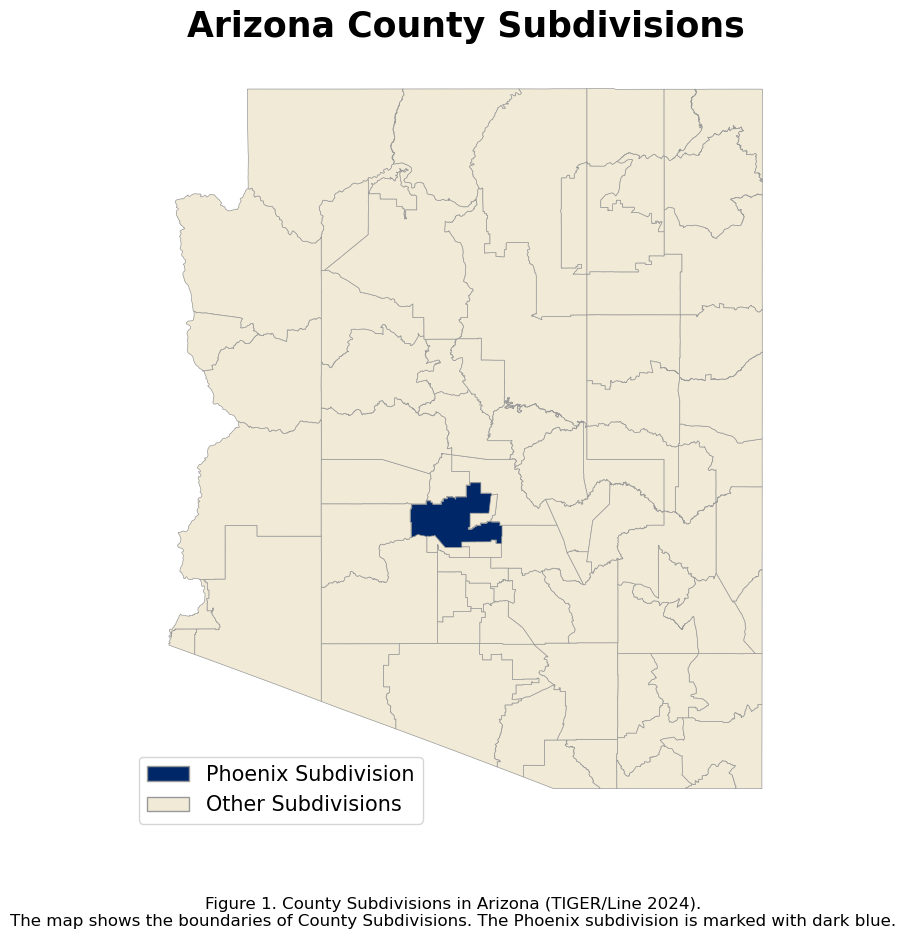

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot all of the subdivisons in Arizona
subdivisions.plot(
    ax=ax,
    color = '#F0EAD6',
    edgecolor="0.6",
    linewidth=0.5
)

# Plot all of the subdivisons in Arizona
subdivisions_phoenix.plot(
    ax=ax,
    color = '#002868',
    edgecolor="0.6",
    linewidth=0.5
)


legend_elements = [
    Patch(facecolor='#002868', edgecolor='0.6', label='Phoenix Subdivision'),
    Patch(facecolor='#F0EAD6', edgecolor='0.6', label='Other Subdivisions')
]
ax.legend(handles=legend_elements, loc= (0,0), fontsize=15, frameon=True)

# Add title and caption for better context
ax.set_title('Arizona County Subdivisions', fontsize=25, weight='bold', pad=12)
plt.figtext(0.5, 0.01, "Figure 1. County Subdivisions in Arizona (TIGER/Line 2024).\nThe map shows the boundaries of County Subdivisions. The Phoenix subdivision is marked with dark blue.", wrap=True, horizontalalignment='center', fontsize=12)

ax.axis('off')
plt.show()

### Prepare Biodiversity Intactness Data
This section retrieves and processes the Biodiversity Intactness Index (BII) raster data from Microsoft Planetary Computer.
***

In order to conduct this analysis we need to import the [Impact Observatory's Biodiversity Intactness](https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview) data from 2017 to 2020. In order to access it we must first connect to the Microsoft Planetary Computer data catalogue and then search for the desired data and area.

In [22]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Specify desired area
bbox_phoenix = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search catalog 
search = catalog.search(collections=["io-biodiversity"], 
                        bbox=bbox_phoenix)

# Retrieve items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


The data then needs to be searched for areas within the `bbox_pheonix` declared above.

We can then specify which years we want to access, and view the pre-rendered image within those years

In [5]:
bii_2017, bii_2020 = (items[3], items[0])

# View plots side by side
display(HTML(f"""
<table>
    <tr>
        <th style = "text-align: center;">2017</th>
        <th style = "text-align: center;">2020</th>
    </tr>
    <tr>
        <td><img src='{bii_2017.assets['rendered_preview'].href}' style="width: 300px;"/></td>
        <td><img src='{bii_2020.assets['rendered_preview'].href}' style="width: 300px;"/></td>
    </tr>
</table>
"""))

2017,2020
,


The raster data can then be opened for both of the years

In [ ]:
raster_2017, raster_2020 = (rioxr.open_rasterio(bii_2017.assets['data'].href),
                            rioxr.open_rasterio(bii_2020.assets['data'].href))
raster_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Since there is only one band in the data we can remove it from both raster files.

In [ ]:
# Remove length one dimension (band)
raster_2017, raster_2020 = (raster_2017.squeeze().drop_vars('band'),
                            raster_2020.squeeze().drop_vars('band'))

print("Sizes of dimensions:", 
      "\n    2017 Raster:", dict(raster_2017.sizes), 
      "\n    2020 Raster:", dict(raster_2020.sizes))

Sizes of dimensions: 
    2017 Raster: {'y': 7992, 'x': 7992} 
    2020 Raster: {'y': 7992, 'x': 7992}


The following code will clip the rasters so that they match the exact range of the pheonix subdivision which was made earlier. 

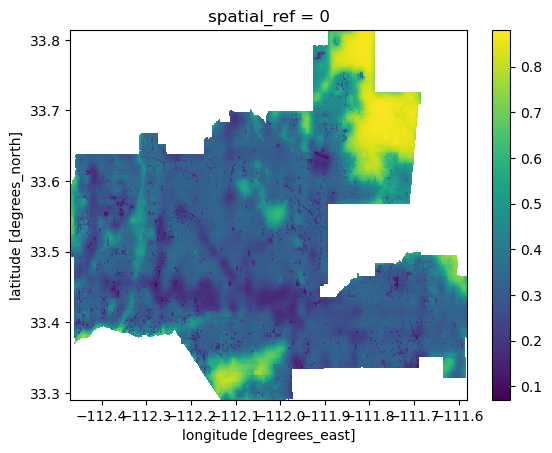

In [ ]:
# Match CRSs and verify update
subdivisions_phoenix_match = subdivisions_phoenix.to_crs(raster_2017.rio.crs)
assert subdivisions_phoenix_match.crs == raster_2017.rio.crs

raster_2017_step1, raster_2020_step1 = (raster_2017.rio.clip_box(*subdivisions_phoenix_match.total_bounds),
                                        raster_2020.rio.clip_box(*subdivisions_phoenix_match.total_bounds))

raster_2017_clipped, raster_2020_clipped = (raster_2017_step1.rio.clip(subdivisions_phoenix_match.geometry),
                                        raster_2020_step1.rio.clip(subdivisions_phoenix_match.geometry))

# View
raster_2017_clipped.plot.imshow()

Using this new clipped data we can now find the percent of area in Phoenix subdivision which has a BII >= 0.75 in each year. This is done by by dividing the number of pixels (100 meter areas) meeting the condition (>= 0.75) by the total number of pixels in the raster.

In [ ]:
percent_2017 = ((raster_2017_clipped >= 0.75).sum().item() / raster_2017_clipped.count().item()) * 100 
percent_2020 = ((raster_2020_clipped >= 0.75).sum().item() / raster_2020_clipped.count().item()) * 100 

# Print Results
print("Percent of Area With BII >= 0.75",
      "\n    2017:", percent_2017,
      "\n    2020:", percent_2020)

Percent of Area With BII >= 0.75 
    2017: 7.125184529081784 
    2020: 6.491290227339828


### Plot of 2020 Data Overlayed With Areas That Fell Below 0.75 Since 2017:
***

The map below visualizes the current state of biodiversity in the Phoenix subdivision (2020) while highlighting areas that have experienced significant biodiversity loss since 2017. Areas shown in red represent locations where the BII has fallen below the 0.75 threshold—a commonly used benchmark for ecosystem intactness—during this three-year period.

**Visualization:** The final map uses a Yellow-Green color scheme to represent the 2020 BII values, with green areas indicating higher biodiversity intactness. Red overlay marks the areas of concern where biodiversity has declined below the critical threshold.

In [ ]:
# Create Mask
lost_area = (raster_2017_clipped >= 0.75) & (raster_2020_clipped < 0.75)

# Remove false values
lost_area = lost_area.where(lost_area)

### Visualizing Age Demographics by Fire Region
The map below visualizes the state of biodiversity in the Phoenix subdivision during 2020 while highlighting areas that have experienced significant biodiversity loss since 2017. Areas shown in red represent locations where the BII has fallen below the 0.75, indicating that 25% of the biodivserity has been lost.

Text(0.5, 0.01, 'Figure 2. Biodiversity Intactness in Pheonix in 2020.\n Red areas mark places where the index has fallen below 0.75 since 2017')

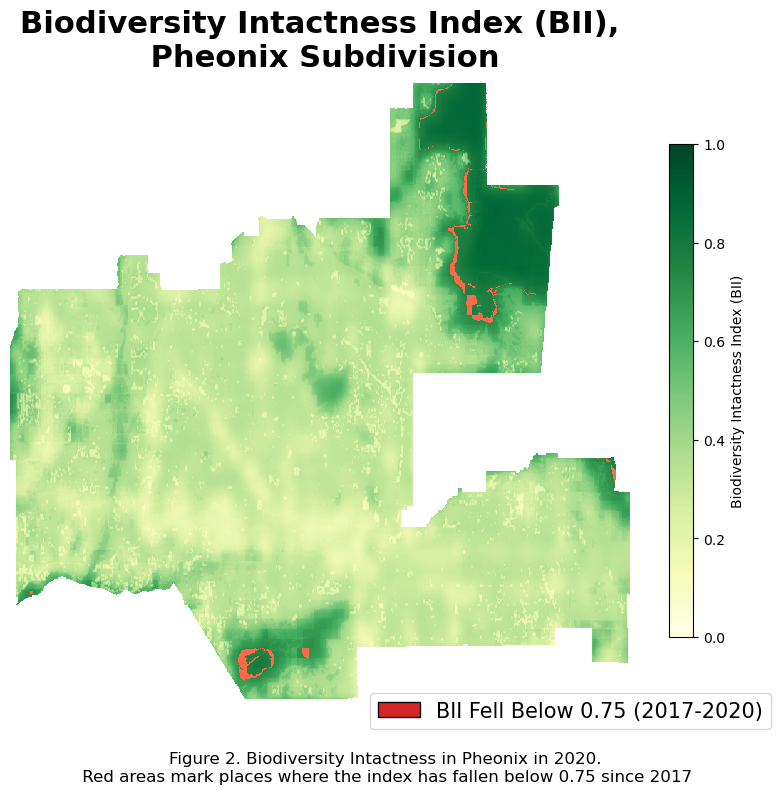

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot 2020 Data 
im = raster_2020_clipped.plot.imshow(
    ax=ax,
    vmin=0,
    vmax=1,
    cmap='YlGn', 
    add_colorbar=True,
    cbar_kwargs={'label': 'Biodiversity Intactness Index (BII)', 'shrink': 0.8}
)

# Overlay Area Lost
lost_area.plot.imshow(
    ax=ax,
    cmap='Reds',
    add_colorbar=False,
    vmin=0.5,
    vmax=1.5,
    interpolation='nearest' # 'nearest' is faster than interpolation
)

legend_elements = [
    Patch(facecolor='#d62728', edgecolor='black', label='BII Fell Below 0.75 (2017-2020)')
]
ax.legend(handles=legend_elements, loc=(.58, -0.05), fontsize=15, frameon=True, facecolor='white')

# Remove axis (as requested)
ax.axis('off')

# Add Labels and Titles
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Biodiversity Intactness Index (BII),\n Pheonix Subdivision", fontsize=22, weight='bold', pad=12)
plt.figtext(0.5, 0.01, "Figure 2. Biodiversity Intactness in Pheonix in 2020.\n Red areas mark places where the index has fallen below 0.75 since 2017", wrap=True, horizontalalignment='center', fontsize=12)


***
### Results
***


The plot reveals that the majority of land area within Phoenix County had already experienced significant biodiversity loss prior to 2017. Only a few small, fragmented patches of high biodiversity remain—primarily in mountainous regions, where topography may have afforded some protection. However, even these isolated refuges appear to be shrinking over time, as areas of low biodiversity (shown in red) increasingly encroach upon the remaining biodiverse zones.

Collectively, these findings underscore the urgent need for sustained monitoring and targeted conservation efforts to protect the county’s few remaining biodiverse habitats before they are further degraded or lost entirely.